# SMBH luminosity function

Juan Urrutia, December 2025

## Imports

In [233]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import optimize, stats
from scipy.misc import derivative
from scipy.interpolate import RegularGridInterpolator,interp1d,LinearNDInterpolator, BSpline, make_interp_spline
from scipy.integrate import quad, fixed_quad, quadrature, simps, romberg, trapezoid, nquad, dblquad, cumulative_trapezoid
from scipy.stats import qmc
from IPython.display import display, Math
import pickle
import os

## General Cosmology

In [5]:
#Constants and cosmological parameters 
kpc=1;
s=1;
kg=1;
meter = 3.24e-20*kpc;
G = 6.674e-11*meter**3/kg/s**2;
c = 2.998e8*meter/s;
Msun = 1.99e30*kg;
h = 0.674;
𝛔8 = 0.811;
ΩM = 0.315;
Ωb = 0.0493;
zeq = 3402;
T0 = 2.7255;
ns = 0.965;

#Densities

def solve_Omega_R():
    return ΩM * (1 + zeq)**3 / (1 + zeq)**4    
ΩR = solve_Omega_R()
ΩL = 1 - ΩM - ΩR
Ωc = ΩM - Ωb
H0 = 100 * h * meter
def AH(z):
    return np.sqrt(ΩM * (1 + z)**3 + ΩR * (1 + z)**4 + ΩL)
def H(z):
    return H0 * AH(z)
def ΩMz(z):
    return ΩM * (1 + z)**3 / AH(z)**2
def ΩLz(z):
    return ΩL / AH(z)**2
𝜌c = 3 * H0**2 / (8 * np.pi * G)
Ω0 = 0.32
Ωb = 0.05
𝜌0 = Ω0 * 277.5 * h**2
𝜌M0 = 𝜌c * ΩM / Msun * kpc**3
keq = H(zeq)/(1+zeq)*kpc/c;

# Distances
logz_grid = np.arange(-6, 4.01, 0.01)
z_vals = 10 ** logz_grid
dc_points = []
for z in z_vals:
    if z == 0:
        dc_points.append(0)
    else:
        integrand = lambda x: c / H(x) / kpc
        val, _ = quad(integrand, 0, z,epsabs=1e-12,epsrel=1e-12)
        dc_points.append(val)
dc = interp1d(z_vals, dc_points, kind='linear', fill_value="extrapolate")

def DVc(z):
    dz = 1e-1
    dcdz = (dc(z + dz) - dc(z- dz)) / (2*dz)
    return 4 * np.pi * dc(z)**2 * dcdz
    
def zDLf(DL):
    def func(z):
        return (1 + z) * dc(z) - DL
    sol = root_scalar(func, bracket=[0, 2e3], method='brentq')
    return sol.root if sol.converged else np.nan
def DLz(z):
    return (1 + z) * dc(z)
    
def tza(z):
    integrand = lambda x: 1 / ((1 + x) * H(x))
    return quad(integrand, z, np.inf)[0]
tz_points = np.concatenate([np.linspace(-0.999, 0, 200), np.linspace(0.0001, 100, 300)])
tz_vals = [tza(z) for z in tz_points]
tz = interp1d(tz_points, tz_vals, kind='cubic', fill_value="extrapolate")
zt = interp1d(tz_vals, tz_points, kind='cubic', fill_value="extrapolate")

#Growth of perturbations

def Dg(z):
    return 5/2*ΩMz(z)/(ΩMz(z)**(4/7)-ΩLz(z)+(1+ΩMz(z)/2)*(1+ΩLz(z)/70))/(1+z)/0.78694
def 𝛿(z):
    return 3 * (12 * np.pi)**(2/3) / 20 * (1 + 0.123 * np.log10(ΩL * (1 + z)**3 / (ΩL * (1 + z)**3 + 1 -ΩL)))
def 𝛿c(z):
    return 3 / 5 * (3 * np.pi / 2)**(2/3) / Dg(z)

In [6]:
# Matter power spectrum

def T(kk):
    ksilk = 1.6 * (Ωb * h**2)**0.52 * (ΩM * h**2)**0.73 * (1 + (10.4 * ΩM * h**2)**-0.95) / 1e3
    a1 = (46.9 * ΩM * h**2)**0.67 * (1 + (32.1 * ΩM * h**2)**-0.532)
    a2 = (12.0 * ΩM * h**2)**0.424 * (1 + (45.0 * ΩM * h**2)**-0.582)
    b1 = 0.944 * (1 + (458 * ΩM * h**2)**-0.708)**-1
    b2 = (0.395 * ΩM* h**2)**(-0.026)
    alpha_cnum = a1**(-Ωb / ΩM) * a2**(-(Ωb / ΩM)**3)
    beta_cnum = 1 / (1 + b1 * ((Ωc / ΩM)**b2 - 1))
    def q(k): return k / (13.41 * keq)
    def C1(k, alpha_c): return 14.2 / alpha_c + 386 / (1 + 69.9 * q(k)**1.08)
    def To1(k, alpha_c, beta_c): return np.log(np.e + 1.8 * beta_c * q(k)) / (np.log(np.e + 1.8 * beta_c * q(k)) + C1(k, alpha_c) * q(k)**2)
    s2 = 44.5 * np.log(9.83 / (ΩM * h**2)) / np.sqrt(1 + 10 * (Ωb * h**2)**(3/4)) * 1e3
    def f(k): return 1 / (1 + (k * s2 / 5.4)**4)
    def Tc(k): return f(k) * To1(k, 1, beta_cnum) + (1 - f(k)) * To1(k, alpha_cnum, beta_cnum)
    def jo(x): return np.sin(x) / x
    def g2(y): return y * (-6 * np.sqrt(1 + y) + (2 + 3 * y) * np.log((np.sqrt(1 + y) + 1) / (np.sqrt(1 + y) - 1)))
    zeq = 2.50e4 * ΩM * h**2 * (T0 / 2.7)**-4
    b3 = 0.313 * (ΩM * h**2)**-0.419 * (1 + 0.607 * (ΩM * h**2)**0.674)
    b4 = 0.238 * (ΩM * h**2)**0.223
    zd = 1291 * (ΩM * h**2)**0.251 / (1 + 0.659 * (ΩM * h**2)**0.828) * (1 + b3 * (Ωb * h**2)**b4)
    Rd = 31.5 * Ωb * h**2 * (T0 / 2.7)**-4 * (zd / 1e3)**-1
    alpha_b = 2.07 * keq * s2 * (1 + Rd)**(-3/4) * g2((1 + zeq) / (1 + zd))
    beta_b = 0.5 + Ωb / ΩM + (3 - 2 * Ωb / ΩM) * np.sqrt(1 + (17.2 * ΩM * h**2)**2)
    beta_node = 8.41 * (ΩM * h**2)**0.435
    def s3(k): return s2 / (1 + (beta_node / (k * s2))**3)**(1/3)
    def Tb(k): return (To1(k, 1, 1) / (1 + (k * s2 / 5.2)**2) + alpha_b / (1 + (beta_b / (k * s2))**3) * np.exp(-(k / ksilk)**1.4)) * jo(k * s3(k))
    return Ωb / ΩM * Tb(kk) + Ωc / ΩM * Tc(kk)
    
def CapitalDelta(k):
    delta_h = 0.00005
    return np.sqrt(delta_h**2 * (c * k / H0)**(3 + ns) * np.abs(T(k))**2)

def P(k):
    return CapitalDelta(k)**2 * (2 * np.pi**2) / k**3

def j1(x):
    return (x * np.cos(x) - np.sin(x)) / x**2

R8 = 8 / h * 1e3

### DM dependent terms

In [7]:
# Matter density variance in CDM 
def WFT(x):
   return 3*(np.sin(x)-x*np.cos(x))/(x**3)
def 𝛔f(M):
    def r(Mc):
        return (3*Mc/(4*np.pi*𝜌M0))**(1/3)
    val, _ = quad(lambda logk:10**(3*logk) * WFT(r(M)*10**logk)**2 * P(10**logk), -20, 20, epsrel=1e-2)
    return 1/(np.sqrt(2)*np.pi) * np.sqrt(np.log(10)*val)
    
log10m_vals = np.arange(-16, 32.1, 0.1)
m_vals = 10**log10m_vals
𝛔2_vals = np.array([𝛔f(m) for m in m_vals])
𝛔2_interp = make_interp_spline(m_vals, 𝛔2_vals, k=1)
def 𝛔CDM2(M):
    ref_mass = 2.7803939422903778e14
    return 𝛔8 / 𝛔2_interp(ref_mass) * 𝛔2_interp(M)
𝛔CDM_vals = np.array([𝛔CDM2(m) for m in m_vals])
𝛔CDM = make_interp_spline(m_vals,𝛔CDM_vals, k=1)
d𝛔dM= 𝛔CDM.derivative()

## GW physics

In [8]:
def m1m2(Mc, eta):
    s = np.sqrt(1.0 - 4.0 * eta)
    A = 1.0 + s + eta * (-5.0 - 3.0 * s + (5.0 + s) * eta)
    A5 = np.power(A, 1.0 / 5.0)
    m1 = Mc * A5 / (np.power(2.0, 1.0 / 5.0) * np.power(eta, 3.0 / 5.0))
    m2 = -Mc * (-1.0 + s + 2.0 * eta) * A5 / (2.0 * np.power(2.0, 1.0 / 5.0) * np.power(eta, 8.0 / 5.0))
    return m1, m2
    
def fGW(Mc, fref, beta):
    return fref * (Mc / 1e9) ** (-beta)

def tenvptGW(f, Mc, fref, beta, alpha, z):
    return ((1 + z) * f / fGW(Mc, fref, beta)) ** alpha

def Amp(Mc, DsL, z):
    return s**(1/6) * np.sqrt(5/24) * c**(-3/2) * (G * (1 + z) * Mc * Msun)**(5/6) / (np.pi**(2/3) * DsL * kpc)

def tf(f, Mc, z):
    return (1 + z) * 5 * c**5 / (256 * (np.pi * (1 + z) * f / s)**(8/3) * (G * Mc * Msun)**(5/3))

def Adtdf(f, Mc, z):
    return -derivative(lambda x: tf(x, Mc, z), f, dx=1e-20) 

def dOmega(Mc, z, f):
    return 2 * np.pi / 5 * (Adtdf(f, Mc, z) * f)**(-1) * f**3 * (Amp(Mc, (1 + z) * dc(z), z) * f**(-7/6))**2 / (G * 𝜌c * s**2)

def MclogOmega(logOmega, z, f):
    target = 10**logOmega
    root_fun = lambda Mc: dOmega(Mc, z, f) - target
    sol = optimize.root_scalar(root_fun, bracket=[1e-12, 1e12])
    return sol.root

def dlnMcdlogOmega(logOmega, z, f):
    return derivative(lambda x: MclogOmega(x, z, f), logOmega, dx=1e-6) / MclogOmega(logOmega, z, f)

def tenv(Mchirp, f, alpha, beta_, fref):
    return 4 * tins(f, Mchirp) * ((Mchirp / 10**9)**(alpha - beta_) * (f / fref)**alpha)

def _r_from_freq(F, Mchirp):
    return (s * (G * Msun * Mchirp)**0.5 / (np.pi * F))**(2/3) / kpc

def teff(logr, alpha, beta_, fref, Mchirp):
    r_min = _r_from_freq(3 * 10**(-8), Mchirp) * 10**3
    r_max = _r_from_freq(10**(-9), Mchirp) * 10**3
    gate = np.heaviside(logr - np.log10(r_min), 0.0) * np.heaviside(np.log10(r_max) - logr, 0.0)
    f_at_r = fr(10**(logr - 3), Mchirp)
    inv1 = (10**6 * year)**(-1) * tins(f_at_r, Mchirp) * 4
    inv2 = (10**6 * year)**(-1) * tenv(Mchirp, f_at_r, alpha, beta_, fref)
    return np.log10(gate * 1 / (1 / inv1 + 1 / inv2))

## EPS structure formation and merger rates

In [9]:
#Basic probabilities 

def pfcST(δ1,S1): return 0.114963*S1**(-3/2)*np.e**(-0.4*δ1**2/S1)*δ1*(1+1.06923*(δ1**2/S1)**(-3/10))
def δel(δ1,S1): return np.sqrt(0.707)*δ1*(1+0.485*(0.707*δ1**2/S1)**(-0.615))
def pfc(δ1,S1,δ2,S2): 
    return np.e**(-(0.840833*δ1+S2**0.615*(0.504729/δ1**0.23-0.504729/δ2**0.23)-0.840833*δ2)**2/(2*(S1-S2)))*(S1-S2)**(-3/2)*(1+0.90121*(δ1**2/S1)**(3/10))*((S1*δ2**2)/(S2*δ1**2))**(3/10)*np.abs(0.840833*δ1+S2**(0.615)*(0.504729/δ1**0.23-0.504729/δ2**0.23)-0.840833*δ2)/(np.sqrt(2*np.pi)*(1+0.90121*(δ2**2/S2)**(3/10)))
def pcond(δp,𝛔p,δm,𝛔m):
    return pfc(δp,𝛔p**2,δm,𝛔m**2)*pfcST(δm,𝛔m**2)/pfcST(δp,𝛔p**2)
#halo mass functions
def dndlogm(M,z):
    return 𝜌0*2*𝛔CDM(M)*np.abs(d𝛔dM(M))*pfcST(δc(z),𝛔CDM(M)**2)

In [10]:
# Probability of a  merger
def dPdM0dt(M,M0,z):
    S = 𝛔CDM(M)**2
    S0 = 𝛔CDM(M0)**2
    a = 0.707
    p = 3/10
    q = 8/10
    nu = 𝛿c(z)**2/S
    nu0 = 𝛿c(z)**2/S0
    A = (1+(a*(𝛿c(z)**2/S0))**(-p))**(-1)
    def ddelta(z):
        return np.abs((δel(𝛿c(z+1e-5),S0)-δel(𝛿c(z-1e-5),S0))/(2*1e-5))
    return  A/np.sqrt(2*np.pi)*(1+(a*nu)**(-p))*(1+(q*nu0)**(-p))/(1+(q*nu)**(-p))*(S/(S0*(S-S0)))**(3/2)*np.exp(-q*(nu0-nu)/2)*ddelta(z)*(1+z)*H(z)*np.abs(2*𝛔CDM(M0)*d𝛔dM(M0))

In [11]:
# CDM merger rate in elliptical collapse
def Rloglog(M1, M2, z):
    Mp =np.minimum(M1, M2)
    M = M1 + M2
    return np.log(10)**2*dndlogm(Mp,z)*M*dPdM0dt(Mp,M,z)

In [37]:
# We first compute the stellar halo mass relation, 
def Az(z):
    return 0.046 * (1.0 + z) ** (-0.38)

def logMaz(z):
    return 11.79 + 0.2 * z

def Gamma_z(z):
    return 0.709 * (1.0 + z) ** (-0.18)

def Beta_z(z):
    return 0.043 * z + 0.92

def Mstar(Mh, z):
    denom = (Mh / (10.0 ** logMaz(z))) ** (-Beta_z(z)) + (Mh / (10.0 ** logMaz(z))) ** (Gamma_z(z))
    return 2.0 * Az(z) * Mh * (denom ** (-1.0))

def Mbulge(mstar):
    return 0.615 * mstar

def logMBH(Mh, z, a, b, c):
    Ms = Mstar(Mh, z)
    return a + b * np.log10(Ms / (10.0 ** 11)) + c * np.log10(1.0 + z)

def logMh(MBH, z, a, b, c):
    def f(Mh):
        return logMBH(Mh, z, a, b, c) - np.log10(MBH)
    Mh_root = optimize.newton(f, np.log10(MBH) + 2.0)
    return np.log10(Mh_root)

# We then connect the mass of the black hole to the mass of the host galaxy
def pMBH(mbh, Mh, z, a, b, c, sigma):
    mu = logMBH(Mh, z, a, b, c)
    return stats.norm.pdf(np.log10(mbh), loc=mu, scale=sigma)

def logmvMin(mbh, z, a, b, c, sigma):
    def f(x):
        return np.log10(pMBH(mbh, x, z, a, b, c, sigma)) + 3.0
    try:
        r = root_scalar(f, bracket=[1.0, 1.0e18])
        x_root = r.root
    except Exception:
        x_root =  optimize.newton(f, x0=mbh)
    return np.log10(x_root)

## Nanograv data and SMBH data

In [13]:
prob = np.load("30f_fs{hd}_ceffyl/density.npy")
year = 365.25 * 24 * 60 * 60
L10rho = np.load("30f_fs{hd}_ceffyl/log10rhogrid.npy")
fNG15 = np.load("30f_fs{hd}_ceffyl/freqs.npy")
DeltafNG15 = np.diff(fNG15)[0]

data = [np.vstack((L10rho, np.exp(prob[j]))).T for j in range(prob.shape[0])]

def OmegaGW(DeltaT, f):
    return 8 * np.pi**4 * (DeltaT**2) * (f**5) * (16.03 * year) / (s * H0)**2

PNG15_interp = [interp1d(d[:,0], d[:,1], kind='linear', bounds_error=False, fill_value=0.0) for d in data]

class ProbabilityDistribution:
    def __init__(self, pdf_func, a, b):
        self.pdf = pdf_func
        self.a = a
        self.b = b

def _normalize_pdf(pdf_func, a, b, n=10000):
    xs = np.linspace(a, b, n)
    vals = pdf_func(xs)
    area = np.trapz(vals, xs)
    if area == 0:
        return lambda x: 0*x
    return lambda x: pdf_func(x) / area

PNG15 = [ProbabilityDistribution(_normalize_pdf(PNG15_interp[i], data[i][0,0], data[i][-1,0]), data[i][0,0], data[i][-1,0]) for i in range(len(PNG15_interp))]
PNG15 = list(zip(fNG15, PNG15))
PNG15 = PNG15[:14]

def RandomVariate(Pdist, size):
    a, b = Pdist.a, Pdist.b
    xs_grid = np.linspace(a, b, 10000)
    pdf_vals = Pdist.pdf(xs_grid)
    M = np.max(pdf_vals)
    samples = []
    rng = np.random.default_rng()

    while len(samples) < size:
        x_prop = rng.uniform(a, b, size - len(samples))
        u = rng.uniform(0, M, size - len(samples))
        accept = u < Pdist.pdf(x_prop)
        samples.extend(x_prop[accept])
    return np.array(samples)

def findlogOmegaDist(Pf):
    f = Pf[0]
    Pdist = Pf[1]
    rv = RandomVariate(Pdist, 5_000_000)
    y = np.log10(OmegaGW(10.0**rv, f))
    bins = np.round(y / 0.01) * 0.01
    uniq, counts = np.unique(bins, return_counts=True)
    dens = counts * (0.01 / 5_000_000.0)
    return interp1d(uniq, dens, kind='nearest', bounds_error=False, fill_value=0.0)

PNG15logOmega = []

for j in range(len(PNG15)):
    f, Pdist = PNG15[j]
    interp0 = findlogOmegaDist(PNG15[j])
    xmin = np.min(interp0.x)
    xmax = np.max(interp0.x)
    PNG15logOmega.append((f, ProbabilityDistribution(_normalize_pdf(interp0, xmin, xmax), xmin, xmax)))

In [14]:
# Load the pre-processed data
with open("agn_data.pkl", "rb") as f:
    data = pickle.load(f)

# Extract the variables
broadLINEAGNdata = data["broadLINEAGNdata"]
otherAGNdata = data["otherAGNdata"]
dynamicallymeasured = data["dynamicallymeasured"]

print(f"Loaded {len(broadLINEAGNdata)} broad AGN data points")
print(f"Loaded {len(otherAGNdata)} other AGN data points")
print(f"Loaded {len(dynamicallymeasured)} dynamically measured data points")

Loaded 235 broad AGN data points
Loaded 27 other AGN data points
Loaded 70 dynamically measured data points


## Luminosity function of SMBHs

In [ ]:
# DM merger rate from the elliptical collapse EPS formalism
def Rastro(m1, m2, z, a, b, sigma):
    def integrand(logM1, logM2):
        return (
            Rloglog(10**logM1, 10**logM2, z)
            * pMBH(m1, 10**logM1, 0, a, b, 0, sigma)
            * pMBH(m2, 10**logM2,  0, a, b, 0, sigma)
        )
    r1 = [logmvMin(m1, z, a, b, c, sigma), 18.0]
    r2 = [logmvMin(m2, z, a, b, c, sigma), 18.0]
    return nquad(integrand, [r1, r2], opts=[{'epsrel':1e-1}, {'epsrel': 1e-1}])[0]

In [ ]:
# Montecarlo integral over the spread of the SMBH mass stellar mass relation 
def Rastro_qmc(m1, m2, z, a, b, sigma, n):

    lo = min(logmvMin(m1, z, a, b, 0, sigma),logmvMin(m2, z, a, b, 0, sigma))
    hi = 18

    sob = qmc.Sobol(d=2, scramble=False, seed= None)
    u = sob.random(n) 

    logM1 = lo + (hi - lo) * u[:, 0]
    logM2 = lo + (hi - lo) * u[:, 1]

    M1 = 10.0 ** logM1
    M2 = 10.0 ** logM2

    vals = (
        Rloglog(M1, M2, z)  
        * pMBH(m1, M1, 0.0, a, b, 0.0, sigma)
        * pMBH(m2, M2, 0.0, a, b, 0.0, sigma)
    )
    area = (hi - lo) ** 2
    est = area * np.mean(vals)
    err = area * np.std(vals) / np.sqrt(n)
    return est

# To use directly in the P^1 function 

def Rlocal(m1, m2, z):
    return  Rastro_qmc(m1, m2, z, 9, 1.5, 0.5, 2**10)

In [ ]:
def build_and_save_Rastro_grid(a, b, sigma, n=2**12, m_range=(1e5, 1e11), m_points=40, z_range=(0.0, 3.0), z_points=10, filename='Rastro_grid.npz'):
    
    # Create grids
    log_m1_grid = np.linspace(np.log10(m_range[0]), np.log10(m_range[1]), m_points)
    log_m2_grid = np.linspace(np.log10(m_range[0]), np.log10(m_range[1]), m_points)
    z_grid = np.linspace(z_range[0], z_range[1], z_points)
    
    m1_grid = 10**log_m1_grid
    m2_grid = 10**log_m2_grid
    
    values = np.zeros((m_points, m_points, z_points))
    
    print(f"Computing grid:{m_points*m_points*z_points} points")
    
    total = m_points * m_points * z_points
    count = 0
    
    for i, m1 in enumerate(m1_grid):
        for j, m2 in enumerate(m2_grid):
            for k, z in enumerate(z_grid):
                try:
                    values[i, j, k] = Rastro_qmc(m1, m2, z, a, b, sigma, n)
                except:
                    values[i, j, k] = 0.0
                
                count += 1
                if count % 200 == 0:
                    print(f"  {count}/{total} ({100*count/total:.1f}%)")
    
    # Save everything as numpy arrays
    np.savez(filename,
             log_m1_grid=log_m1_grid,
             log_m2_grid=log_m2_grid,
             z_grid=z_grid,
             values=values,
             a=a,
             b=b,
             sigma=sigma,
             n=n)
    
    print(f"✓ Saved grid data to {filename}")
    print(f"  File size: {os.path.getsize(filename) / 1024:.1f} KB")

In [650]:
def load_Rastro_interpolator(filename='Rastro_grid.npz', method='linear'):
    
    data = np.load(filename)
    
    log_m1_grid = data['log_m1_grid']
    log_m2_grid = data['log_m2_grid']
    z_grid = data['z_grid']
    values = data['values']
    
    # Print info
    print(f"✓ Loaded grid from {filename}")
    print(f"  Parameters: a={data['a']}, b={data['b']}, sigma={data['sigma']}")
    print(f"  Grid shape: {values.shape}")
    print(f"  m1 range: [{10**log_m1_grid[0]:.1e}, {10**log_m1_grid[-1]:.1e}]")
    print(f"  z range: [{z_grid[0]}, {z_grid[-1]}]")
    
    # Build interpolator
    interpolator = RegularGridInterpolator(
        (log_m1_grid, log_m2_grid, z_grid),
        np.log10(values),
        method=method,
        bounds_error=False,
        fill_value=-100
    )
    
    # Return a callable function
    def Rastro_interp(m1, m2, z):
        log_m1 = np.log10(np.maximum(m1, 1e-10))
        log_m2 = np.log10(np.maximum(m2, 1e-10))
        
        if np.isscalar(log_m1):
            points = np.array([[log_m1, log_m2, z]])
            return 10**float(interpolator(points))
        else:
            points = np.column_stack([log_m1, log_m2, z])
            return 10**float(interpolator(points))
    
    return Rastro_interp

In [ ]:
# This computes the Rastro grid and saves it, you can compute this only once 
build_and_save_Rastro_grid(a=9.0, b=1.5, sigma=0.5)

Computing grid: 40×40×10 = 16000 points
  200/16000 (1.2%)
  400/16000 (2.5%)
  600/16000 (3.8%)
  800/16000 (5.0%)
  1000/16000 (6.2%)
  1200/16000 (7.5%)
  1400/16000 (8.8%)
  1600/16000 (10.0%)
  1800/16000 (11.2%)
  2000/16000 (12.5%)
  2200/16000 (13.8%)
  2400/16000 (15.0%)
  2600/16000 (16.2%)
  2800/16000 (17.5%)
  3000/16000 (18.8%)
  3200/16000 (20.0%)
  3400/16000 (21.2%)
  3600/16000 (22.5%)
  3800/16000 (23.8%)
  4000/16000 (25.0%)
  4200/16000 (26.2%)
  4400/16000 (27.5%)
  4600/16000 (28.8%)
  4800/16000 (30.0%)
  5000/16000 (31.2%)
  5200/16000 (32.5%)
  5400/16000 (33.8%)
  5600/16000 (35.0%)


In [640]:
# Now you load the data and construct the interpolator 
Rastro_interp = load_Rastro_interpolator('Rastro_grid.npz')

✓ Loaded grid from Rastro_grid.npz
  Parameters: a=9.0, b=1.5, sigma=0.5
  Grid shape: (20, 20, 20)
  m1 range: [1.0e+06, 1.0e+11]
  z range: [0.0, 3.0]


/var/folders/pg/30zt2zh52p546f6kb2dn1w9m0000gn/T/ipykernel_39606/3642089255.py:20: RuntimeWarning: divide by zero encountered in log10
  np.log10(values),


In [642]:
# We apply the same integral technique for P^1

def PlogOmegaScal_qmc(R, logOmega, f, pbh, fref, alpha, beta, n_outer):

    z_grid = np.linspace(0.01, 2.99, 50)

    Mc_grid = np.array([MclogOmega(logOmega, zi, f) for zi in z_grid])
    Mc_interp = interp1d(z_grid, Mc_grid, kind='linear', fill_value='extrapolate')
    
    # Generate Sobol samples
    sob = qmc.Sobol(d=2, scramble=True, seed=None)
    u = sob.random(n_outer)
    
    # Map to integration domain (avoiding exact boundaries)
    eta_lo, eta_hi = 1e-3, 0.249
    z_lo, z_hi = 0.01, 2.99
    
    eta = eta_lo + (eta_hi - eta_lo) * u[:, 0]
    z = z_lo + (z_hi - z_lo) * u[:, 1]
    
    # Compute Mc values (interpolated - fast!)
    Mc = Mc_interp(z)
    m1, m2 = m1m2(Mc, eta)
    
    # Compute integrand values with safety checks
    vals = np.zeros(n_outer)
    
    for i in range(n_outer):
        # Safe discriminant
        disc = 1.0 - 4.0 * eta[i]
        if disc <= 1e-10:
            vals[i] = 0.0
            continue
        
        try:
            kernel = 2.0 / (np.sqrt(disc) * eta[i])
            
            tenv = tenvptGW(f, Mc[i], fref, beta, alpha, z[i])
            env_factor = 1.0 / (1.0 + max(tenv, 1e-10)**(-1.0))
            
            adtdf = Adtdf(f, Mc[i], z[i])
            dvc = DVc(z[i])
            rastro = R(m1[i], m2[i], z[i])
            
            vals[i] = (
                kernel * 0.69 * adtdf * f * env_factor
                * dvc / (1.0 + z[i]) * pbh * rastro
            )
            
            # Set to 0 if not finite
            if not np.isfinite(vals[i]):
                vals[i] = 0.0
                
        except Exception:
            vals[i] = 0.0
    
    # Filter finite values and compute mean
    valid_mask = np.isfinite(vals) & (vals != 0)
    vals_clean = vals[valid_mask]
    
    if len(vals_clean) == 0:
        return 0.0
    
    # Compute integral
    area = (eta_hi - eta_lo) * (z_hi - z_lo)
    result = area * np.mean(vals_clean)
    
    return result

Now we want to compare this to the functions from Mathematica to cross-check everything works

In [643]:
yvalues=[Rastro_qmc(1e8, 10**logm, 0., 9., 1.4, 0.5,  1000) for logm in np.linspace(6, 11, 30)]
yvalues2=[Rastro_qmc(1e9, 10**logm, 0., 9., 1.4, 0.5, 1000) for logm in np.linspace(6, 11, 30)]
yvalues3=[Rastro_qmc(1e10, 10**logm, 0., 9., 1.4, 0.5, 1000) for logm in np.linspace(6, 11, 30)]
yvaluesa=[Rastro_interp(1e8, 10**logm, 0.) for logm in np.linspace(6, 11, 30)]
yvalues2a=[Rastro_interp(1e9, 10**logm, 0) for logm in np.linspace(6, 11, 30)]
yvalues3a=[Rastro_interp(1e10, 10**logm,0) for logm in np.linspace(6, 11, 30)]
xvalues=[10**z for z in np.linspace(6, 11, 30)]

/Users/juanurrutia/anaconda3/lib/python3.11/site-packages/scipy/stats/_qmc.py:763: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  sample = self._random(n, workers=workers)
/var/folders/pg/30zt2zh52p546f6kb2dn1w9m0000gn/T/ipykernel_39606/3642089255.py:33: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return 10**float(interpolator(points))


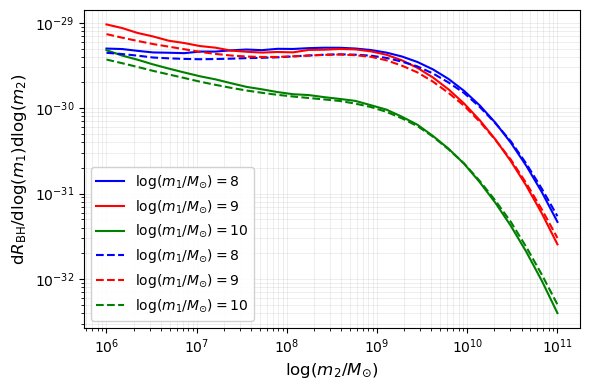

In [644]:
plt.figure(figsize=(6, 4))
# Plot with labels and custom styles
plt.plot(xvalues, yvalues, label=r'$\log(m_1/M_{\odot})=8$', color='blue')
plt.plot(xvalues, yvalues2, label=r'$\log(m_1/M_{\odot})=9$',color='red')
plt.plot(xvalues, yvalues3, label=r'$\log(m_1/M_{\odot})=10$', color='green')
plt.plot(xvalues, yvaluesa, label=r'$\log(m_1/M_{\odot})=8$', color='blue',linestyle='--')
plt.plot(xvalues, yvalues2a, label=r'$\log(m_1/M_{\odot})=9$',color='red',linestyle='--')
plt.plot(xvalues, yvalues3a, label=r'$\log(m_1/M_{\odot})=10$', color='green',linestyle='--')
# Log scales
plt.xscale('log')
plt.yscale('log')
# Labels with optional LaTeX formatting
plt.xlabel(r'$\log(m_2/M_{\odot})$', fontsize=12)
plt.ylabel(r'${\rm d} R_{\rm BH}/{\rm d}\log(m_1){\rm d}\log(m_2)$', fontsize=12)  # Use r'' for LaTeX
# Grid for both major and minor ticks
plt.grid(True, alpha=0.3, which='both', linestyle='-', linewidth=0.5)
# Legend with styling
plt.legend(loc='lower left', framealpha=0.9, fontsize=10, frameon=True)
plt.tight_layout()
plt.show()

In [645]:
yval1= [PlogOmegaScal_qmc(Rastro_interp, logOmega, 1e-9, 0.1, 15*10**-9, 5/8, 8/3, 2**10) for logOmega in np.linspace(-25, -5, 10)]
xval1= [10**logOmega for logOmega in np.linspace(-25, -5, 10)]

/var/folders/pg/30zt2zh52p546f6kb2dn1w9m0000gn/T/ipykernel_39606/347254025.py:22: DeprecationWarning: scipy.misc.derivative is deprecated in SciPy v1.10.0; and will be completely removed in SciPy v1.12.0. You may consider using findiff: https://github.com/maroba/findiff or numdifftools: https://github.com/pbrod/numdifftools
  return -derivative(lambda x: tf(x, Mc, z), f, dx=1e-20)
/var/folders/pg/30zt2zh52p546f6kb2dn1w9m0000gn/T/ipykernel_39606/3642089255.py:33: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return 10**float(interpolator(points))


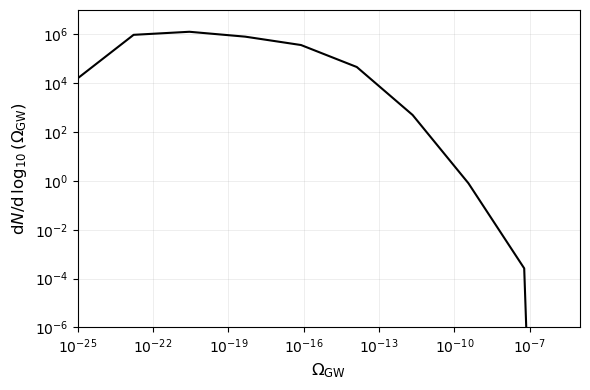

In [646]:
plt.figure(figsize=(6, 4))
# Plot with labels and custom styles
plt.plot(xval1, yval1, color='black')
# Set x-axis range
plt.xlim(1e-25, 1e-5)  # min, max
# Set y-axis range
plt.ylim(1e-6, 1e7)  # min, max
# Log scales
plt.xscale('log')
plt.yscale('log')
# Labels with optional LaTeX formatting
plt.xlabel(r'$\Omega_{\rm GW}$', fontsize=12)
plt.ylabel(r'${\rm d}N/{\rm d\,\log_{10}\left(\Omega_{GW}\right)}$', fontsize=12) 
# Grid for both major and minor ticks
plt.grid(True, alpha=0.3, which='both', linestyle='-', linewidth=0.5)
# Legend with styling
plt.tight_layout()
plt.show()

It works very well, now the idea is to compute the PDF generator from the luminosity function 

In [484]:
# This function has an imput the that is the x-values and y-values of the luminosity function and outs the normalized probability of total Omega and 100 distributions of 
# the total Omega values. 

def findOmegatotastro(xs, ys, f0, Delta_f0):  

    Nbin = 50
    Nrel = 10000

    def subdivide(a, b, n):
        return np.linspace(a, b, (n + 1))

    # Work in log space
    log_xdat = np.log10(xs)
    log_ydat = np.log10(ys)
    
    # Create interpolator
    LPlogOmega1 = interp1d(log_xdat, log_ydat, kind='linear', fill_value='extrapolate', bounds_error=False)
    start = log_xdat[0]
    end = log_xdat[-2]
    limit = log_xdat[-1]

    ts = subdivide(start, end, 50)
    Lnorm_vals = []
    for t in ts:
        val, _ = quad(lambda x: 10.0 ** (LPlogOmega1(x)), t, limit)
        Lnorm_vals.append(np.real(np.log10(val)))

    Lnorm = interp1d(ts, np.array(Lnorm_vals), kind='linear',  bounds_error=False, fill_value='extrapolate')

    Ntot = np.log((f0 + Delta_f0) / f0) * (10.0 ** Lnorm(start))

    if Ntot > Nbin:
        def g(x):
            return np.log((f0 + Delta_f0) / f0) * (10.0 ** Lnorm(x)) - Nbin
        sol = optimize.root_scalar(g, bracket=[start, end], method='brentq')
        LOmega_min = sol.root
    else:
        LOmega_min = start

    dOmega_low, _ = quad(
        lambda x: (10.0 ** x) * (10.0 ** LPlogOmega1(x)), start, LOmega_min)
    dOmega_low = np.real(dOmega_low)

    x_pdf = subdivide(LOmega_min, end, 99)
    y_pdf = (10.0 ** np.array([LPlogOmega1(x) for x in x_pdf])) / (10.0 ** Lnorm(LOmega_min))
    PlogOmega1_interp = interp1d(
        x_pdf, y_pdf, kind='linear', bounds_error=False, fill_value='extrapolate')

    cdf = cumulative_trapezoid(y_pdf, x_pdf, initial=0.0)
    cdf /= cdf[-1] if cdf[-1] != 0 else 1.0
    inv_cdf = interp1d(
        cdf, x_pdf, kind='linear', bounds_error=False, fill_value=(x_pdf[0], x_pdf[-1]))

    samples = inv_cdf(np.random.random(size=(Nrel, Nbin)))
    totals = np.sum(10.0 ** samples, axis=1)
    result_vector = dOmega_low + (1.0 / np.log((f0 + Delta_f0) / f0)) * totals

    x_full = subdivide(start, end, 99)
    y_tot = np.array([LPlogOmega1(x) for x in x_full]) - Lnorm(start)
    PlogOmega_tot = interp1d(
        x_full, y_tot, kind='linear', bounds_error=False, fill_value='extrapolate')
    
    return (f0, result_vector, PlogOmega_tot)

In [485]:
dat1=findOmegatotastro(xval1, yval1, 1e-9, 2*1e-9)

/var/folders/pg/30zt2zh52p546f6kb2dn1w9m0000gn/T/ipykernel_39606/3640649422.py:25: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  val, _ = quad(lambda x: 10.0 ** (LPlogOmega1(x)), t, limit)
/var/folders/pg/30zt2zh52p546f6kb2dn1w9m0000gn/T/ipykernel_39606/3640649422.py:25: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  val, _ = quad(lambda x: 10.0 ** (LPlogOmega1(x)), t, limit)


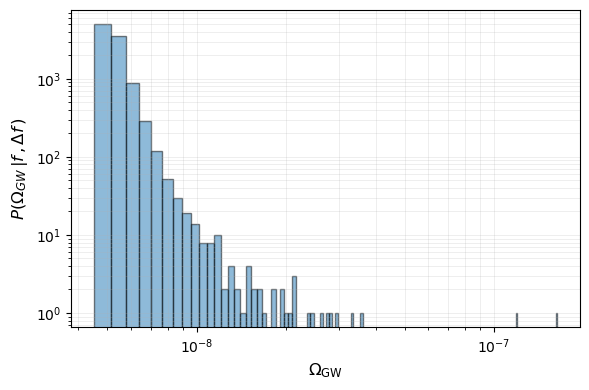

In [486]:
# Plot histogram
plt.figure(figsize=(6,4))
plt.hist(dat1[1], bins=250, edgecolor='black', alpha=0.5)
# Labels with optional LaTeX formatting
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$\Omega_{\rm GW}$', fontsize=12)
plt.ylabel(r'$P\left(\Omega_{GW}\,|f\, ,\Delta f\, \right)$', fontsize=12)  # Use r'' for LaTeX
# Grid for both major and minor ticks
plt.grid(True, alpha=0.3, which='both', linestyle='-', linewidth=0.5)
# Legend with styling
plt.tight_layout()
plt.show()

In [ ]:
sa